# Лабораторная работа №4

ФИО:  **Селифонов Артём Евгеньевич**
Группа: **БИВТ-20-1**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Шаги 1-3

#### cifar100

Этот датасет содержит 100 классов, содержащих по 600 изображений в каждом. На каждый класс приходится 500 train изображений и 100 test изображений. 100 классов в CIFAR-100 сгруппированы в 20 суперклассов. Каждое изображение снабжено меткой "fine" (класс, к которому оно принадлежит) и меткой "coarse" (суперкласс, к которому оно принадлежит).

In [14]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    # transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    # transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

cifar_train = CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
cifar_test = CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

train_dataloader = DataLoader(cifar_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(cifar_test, batch_size=16, shuffle=False)

dataset_sizes = {
    'train': len(cifar_train),
    'test': len(cifar_test)
}

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class_names = cifar_test.classes
print(f'Class names: {class_names}')

Class names: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', '

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
device

device(type='cuda', index=0)

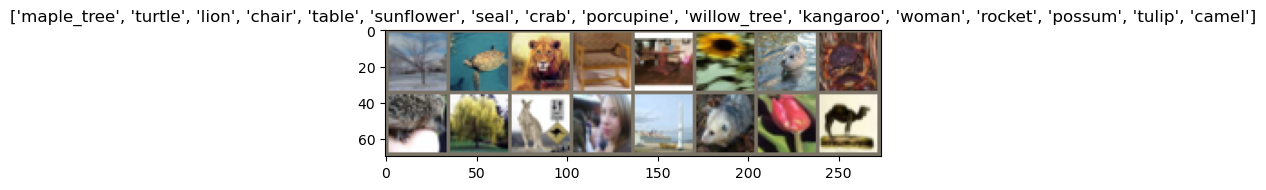

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6, bias=0):
    was_training = model.training
    model.eval()
    images_so_far = 0
    bias_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                bias_so_far += 1
                if bias_so_far < bias:
                    continue
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=2),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),


    nn.BatchNorm2d(64),
    # nn.Softmax2d(),

    nn.Flatten(),

    nn.Linear(23104, 1024),
    nn.ReLU(),
    nn.Linear(1024, 100),
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 3.0654 Acc: 0.2542
test Loss: 2.5557 Acc: 0.3515

Epoch 1/4
----------
train Loss: 2.1236 Acc: 0.4461
test Loss: 2.2193 Acc: 0.4240

Epoch 2/4
----------
train Loss: 1.3356 Acc: 0.6604
test Loss: 2.0250 Acc: 0.4738

Epoch 3/4
----------
train Loss: 1.1843 Acc: 0.6980
test Loss: 1.9988 Acc: 0.4825

Epoch 4/4
----------
train Loss: 1.0664 Acc: 0.7353
test Loss: 1.9879 Acc: 0.4871

Training complete in 2m 14s
Best test Acc: 0.487100


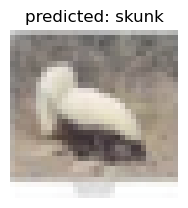

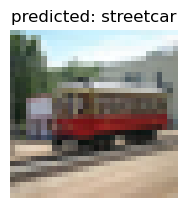

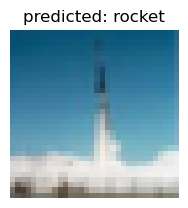

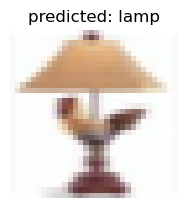

In [20]:
visualize_model(model_fitted, 4, 12)

## Шаг 6

In [21]:
pretrained_train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

pretrained_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

pretrained_cifar_train = CIFAR100(root='./data', train=True, download=True, transform=pretrained_train_transforms)
pretrained_cifar_test = CIFAR100(root='./data', train=False, download=True, transform=pretrained_test_transforms)

pretrained_train_dataloader = DataLoader(pretrained_cifar_train, batch_size=16, shuffle=True)
pretrained_test_dataloader = DataLoader(pretrained_cifar_test, batch_size=16, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
def train_pretrained(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = pretrained_train_dataloader
            if phase == 'test':
                current_dataloader = pretrained_test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [25]:
resnet_model = models.resnet18(weights='DEFAULT')
num_features = resnet_model.fc.in_features

resnet_model.fc = nn.Linear(num_features, 100)

print(num_features)

model_ft = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

512


In [28]:
fitted_resnet = train_pretrained(resnet_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)

Epoch 0/6
----------
train Loss: 0.4609 Acc: 0.8724
test Loss: 0.6237 Acc: 0.8060

Epoch 1/6
----------
train Loss: 0.4608 Acc: 0.8711
test Loss: 0.6277 Acc: 0.8066

Epoch 2/6
----------
train Loss: 0.4594 Acc: 0.8731
test Loss: 0.6267 Acc: 0.8074

Epoch 3/6
----------
train Loss: 0.4621 Acc: 0.8718
test Loss: 0.6230 Acc: 0.8070

Epoch 4/6
----------
train Loss: 0.4603 Acc: 0.8708
test Loss: 0.6239 Acc: 0.8079

Epoch 5/6
----------
train Loss: 0.4631 Acc: 0.8703
test Loss: 0.6251 Acc: 0.8084

Epoch 6/6
----------
train Loss: 0.4627 Acc: 0.8725
test Loss: 0.6270 Acc: 0.8077

Training complete in 16m 44s
Best test Acc: 0.808400


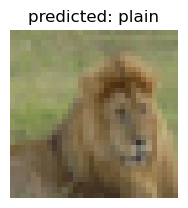

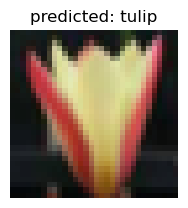

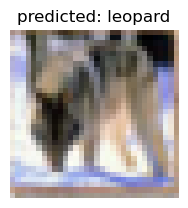

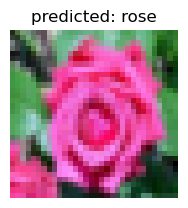

In [57]:
visualize_model(fitted_resnet, 4, 16)

# Выводы

1. Получилось построить свою нейросеть, архитектура получилась намного проще, чем я ожидал. Однако, accuracy больше 0.48 получить не удалось, дальше идёт переобучение на данном датасете.
2. В качестве предобученной модели пытался использовать VGG, но она совсем не обучалась. Выбрал resnet18, получилась хорошая accuracy > 0.8. При этом на тесте не удалось найти большого количества хороших картинок. Есть ощущение, что resnet хорошо справляется с цветами и животными.
3. RTX 3070 мощнее T4 из колаба, однако памяти у 3070 меньше, что становится проблемой при больших моделях.
4. Запустить torch с cuda под виндой очень сложно, пришлось запускать контейнер в докере с предустановленным юпитером и дружить его с PyCharm.
5. Я много времени потратил на то, что бы можно было запихнуть модельку на гпу нативно из-под винды, и поздно начал, что привело к поздней сдаче лабы.